In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image
import cv2

# %tensorflow_version 1.x
import tensorflow as tf

import numpy as np
from numpy.random import seed


import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tqdm import *

#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D, SeparableConv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

print(tf.__version__)

2.4.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_dir= 'drive/My Drive/Hiding Images/Cats and Dogs Dataset'

In [4]:
train_dir= os.path.join(main_dir,'train')
val_dir= os.path.join(main_dir,'validation')

os.listdir(val_dir)

['dogs', 'cats']

In [5]:
height= 256
width= 256
batch_size= 20

seed_S_train= seed(1)
seed_S_val= seed(2)
seed_C_train= seed(3)
seed_C_val= seed(4)

In [6]:
beta= 0.75
# Loss for reveal network
def rev_loss(s_true, s_pred):
# Loss for reveal network is: beta * |S-S'|
  return beta * K.sum(K.square(s_true - s_pred))
# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
# Loss for the full model is: |C-C'| + beta * |S-S'|
  s_true, c_true = y_true[0], y_true[1]
  s_pred, c_pred = y_pred[0], y_pred[1]
  s_loss = rev_loss(s_true, s_pred)

  c_loss = K.sum(K.square(c_true - c_pred))
  return s_loss + c_loss

In [7]:
def get_encoder(h,w,batch_size= batch_size,pi=0.5):
  
  input_S= Input(batch_shape=(batch_size,h,w,3))
  input_C= Input(batch_shape=(batch_size,h,w,3))

  p1= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(input_S)
  p1= BatchNormalization()(p1)
  p1= Dropout(rate= pi)(p1)

  p2= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(p1)
  p2= BatchNormalization()(p2)
  p2= Dropout(rate= pi)(p2)

  p3= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(p2)
  p3= BatchNormalization()(p3)
  p3= Dropout(rate= pi)(p3) 

  p4= Conv2D(filters=30, kernel_size=(4,4), padding='same', activation='relu')(p3)
  p4= BatchNormalization()(p4)
  p4= Dropout(rate= pi)(p4) 

  p5= Conv2D(filters=7, kernel_size=(2,2), padding='same', activation='tanh')(p4)
  p5= BatchNormalization()(p5)
  prepared= Dropout(rate= pi)(p5)

  hiding_input= concatenate([input_C,prepared])

  h1= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(hiding_input)
  h1= BatchNormalization()(h1)
  h1= Dropout(rate= pi)(h1)

  h2= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(h1)
  h2= BatchNormalization()(h2)
  h2= Dropout(rate= pi)(h2)

  h3= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(h2)
  h3= BatchNormalization()(h3)
  h3= Dropout(rate= pi)(h3) 

  h4= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(h3)
  h4= BatchNormalization()(h4)
  h4= Dropout(rate= pi)(h4) 

  h5= Conv2D(filters=30, kernel_size=(4,4), padding='same', activation='relu')(h4)
  h5= BatchNormalization()(h5)
  h5= Dropout(rate= pi)(h5) 

  output_C_prime= Conv2D(filters=3, kernel_size=(2,2), padding='same', activation='tanh')(h5)

  return Model(inputs=[input_S,input_C], outputs=[output_C_prime])

In [8]:
def get_decoder(h,w,batch_size= batch_size,pi=0.5):

  C_prime= Input(batch_shape=(batch_size,h,w,3))

  r1= Conv2D(filters=100, kernel_size=(4,4), padding='same', activation='relu')(C_prime)
  r1= BatchNormalization()(r1)
  r1= Dropout(rate= pi)(r1)

  r2= Conv2D(filters=100, kernel_size=(4,4), padding='same', activation='relu')(r1)
  r2= BatchNormalization()(r2)
  r2= Dropout(rate= pi)(r2)  

  r3= Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(r2)
  r3= BatchNormalization()(r3)
  r3= Dropout(rate= pi)(r3)

  S_prime= Conv2D(filters=3, kernel_size=(2,2), padding='same', activation='relu')(r3)

  return Model(inputs=[C_prime], outputs=[S_prime])

In [24]:
def get_autoencoder(height,width,batch_size= batch_size,pi=0.5):

  input_S = Input(batch_shape=(batch_size,height, width, 3))
  input_C= Input(batch_shape=(batch_size,height, width, 3))

  encoder = get_encoder(height, width, pi=0.7)
  decoder = get_decoder(height, width, pi=0.7)

  opt= Adam(learning_rate=1e-3)

  encoder.compile(optimizer=opt, loss=rev_loss, metrics=['accuracy'])
  decoder.compile(optimizer=opt, loss=rev_loss, metrics=['accuracy'])
  
  output_C_prime = encoder([input_S, input_C])
  output_S_prime = decoder(output_C_prime)

  autoencoder = Model(inputs=[input_S, input_C], outputs=([output_S_prime, output_C_prime]))

  autoencoder.compile(optimizer=opt, loss=full_loss, metrics=['accuracy'])


  return encoder, decoder, autoencoder

In [37]:
encoder, decoder, autoencoder= get_autoencoder(height, width)
inp=autoencoder.input
a= autoencoder(inp)

decoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(20, 256, 256, 3)]       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (20, 256, 256, 100)       4900      
_________________________________________________________________
batch_normalization_49 (Batc (20, 256, 256, 100)       400       
_________________________________________________________________
dropout_49 (Dropout)         (20, 256, 256, 100)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (20, 256, 256, 100)       160100    
_________________________________________________________________
batch_normalization_50 (Batc (20, 256, 256, 100)       400       
_________________________________________________________________
dropout_50 (Dropout)         (20, 256, 256, 100)       0  

In [38]:
args = dict(rotation_range=45,
            rescale= 1.0/255,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
            )

datagen= ImageDataGenerator(**args)

S_train_generator= datagen.flow_from_directory(
                    train_dir,
                    target_size= (height,width),
                    color_mode= 'rgb',
                    batch_size= batch_size,
                    shuffle= True,
                    interpolation= 'bicubic')

C_train_generator= datagen.flow_from_directory(
                    train_dir,
                    target_size= (height,width),
                    color_mode= 'rgb',
                    batch_size= batch_size,
                    shuffle= True,
                    interpolation= 'bicubic')

S_val_generator= datagen.flow_from_directory(
                    val_dir,
                    target_size= (height,width),
                    color_mode= 'rgb',
                    batch_size= batch_size,
                    shuffle= True,
                    interpolation= 'bicubic')

C_val_generator= datagen.flow_from_directory(
                    val_dir,
                    target_size= (height,width),
                    color_mode= 'rgb',
                    batch_size= batch_size,
                    shuffle= True,
                    interpolation= 'bicubic') 


Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [39]:
def train_concat_gen():
  while True:
    X1= S_train_generator.next()
    X2= C_train_generator.next()

    yield [X1[0],X2[0]], [X1[0],X2[0]]

In [40]:
def concat():
  while True:
    X1= S_train_generator.next()
    X2= C_train_generator.next()

    yield [X1[0],X2[0]]  

In [41]:
def val_concat_gen():
  while True:
    X1= S_val_generator.next()
    X2= C_val_generator.next()

    yield [X1[0],X2[0]], [X1[0],X2[0]]

In [42]:
total_train_ims= 2000
total_val_ims= 1000
steps_per_epoch= total_train_ims//batch_size
val_steps= total_val_ims//batch_size

In [43]:
autoencoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(20, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(20, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
model_9 (Functional)            (20, 256, 256, 3)    261688      input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
model_10 (Functional)           (20, 256, 256, 3)    246653      model_9[0][0]             

In [44]:
t_gen=train_concat_gen()
X_train, Y_train = next(t_gen)

In [45]:
print(np.shape(Y_train))

(2, 20, 256, 256, 3)


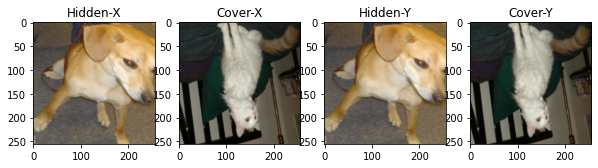

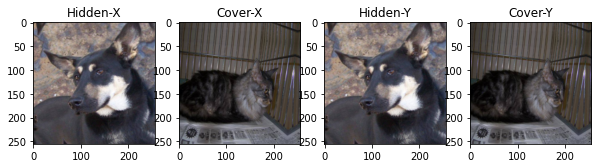

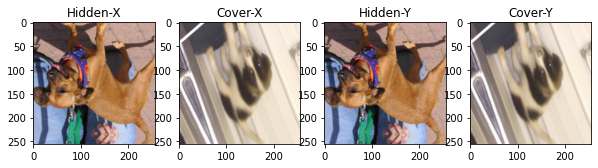

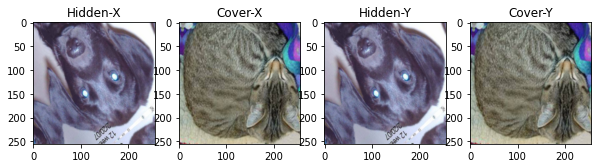

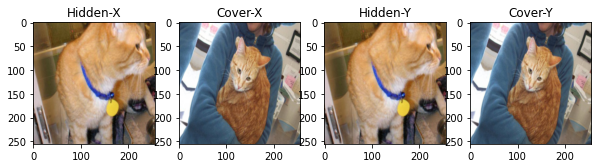

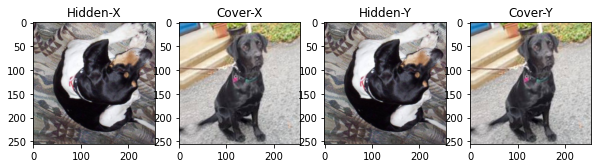

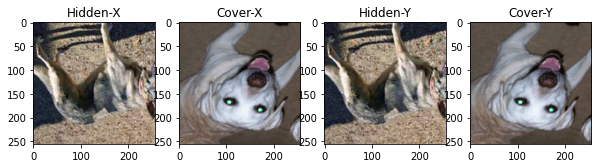

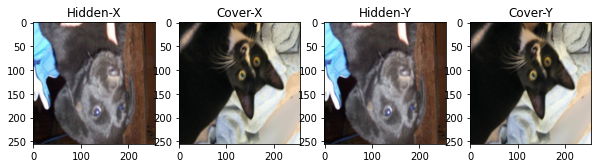

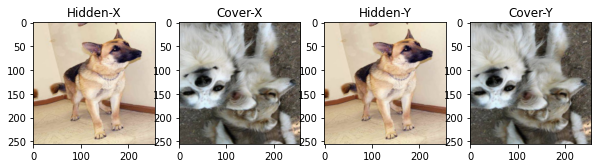

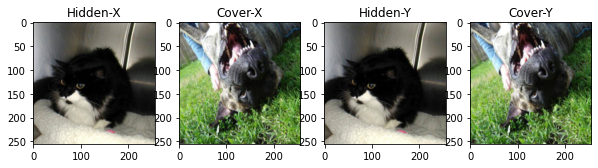

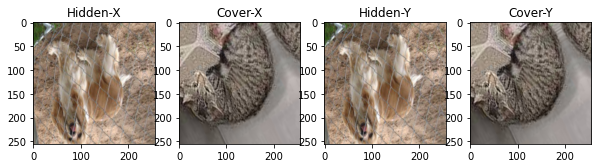

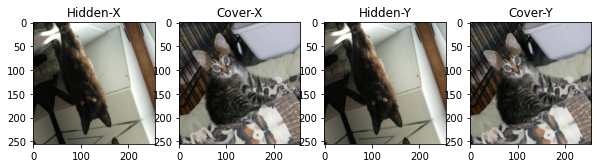

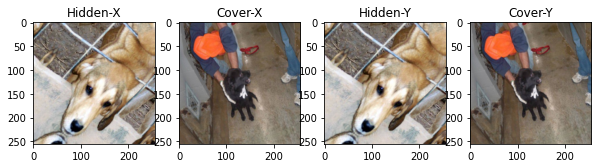

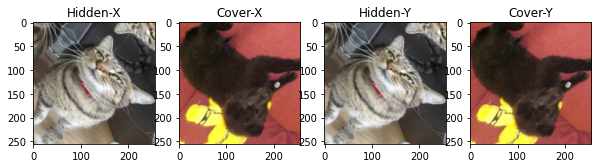

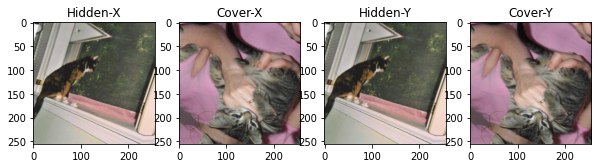

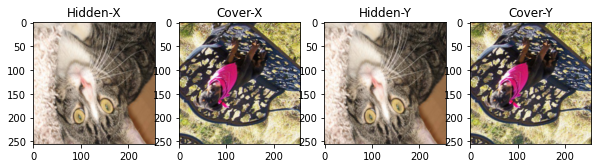

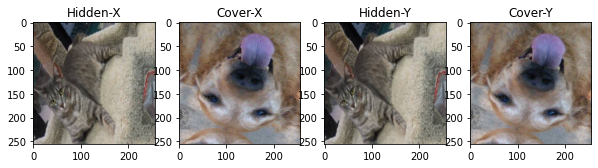

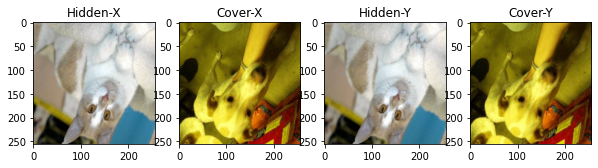

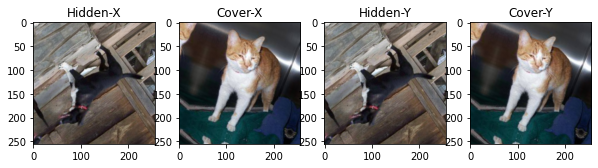

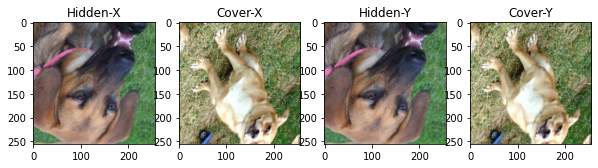

In [46]:
for i in range(batch_size):
    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(1,4,1)
    ax1.set_title('Hidden-X')
    ax1.imshow(X_train[0][i])
    
    
    ax2 = fig.add_subplot(1,4,2)
    ax2.set_title('Cover-X')
    ax2.imshow(X_train[1][i])

    ax3 = fig.add_subplot(1,4,3)
    ax3.set_title('Hidden-Y')
    ax3.imshow(Y_train[0][i])
    
    
    ax4 = fig.add_subplot(1,4,4)
    ax4.set_title('Cover-Y')
    ax4.imshow(Y_train[1][i])
    
    plt.show()

In [48]:
NB_EPOCHS = 500
m= 2000
loss_history=[]

weights_file=os.path.join(main_dir,'WEIGHTS.hdf5')
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

callbacks= [checkpoint]

# autoencoder.load_weights(weights_file)

In [49]:
history= autoencoder.fit(x= train_concat_gen(),
                         epochs= NB_EPOCHS,
                         callbacks= callbacks,
                         validation_data= val_concat_gen(),
                         shuffle= True,
                         steps_per_epoch= steps_per_epoch,
                         validation_steps= val_steps)

Epoch 1/500
100/100 [==============================] - 512s 5s/step - loss: 395859.3584 - model_10_loss: 386008.2222 - model_9_loss: 9851.1741 - model_10_accuracy: 0.3610 - model_9_accuracy: 0.6609 - val_loss: 87481.5312 - val_model_10_loss: 72994.2266 - val_model_9_loss: 14487.3115 - val_model_10_accuracy: 0.1938 - val_model_9_accuracy: 0.6558

Epoch 00001: val_loss improved from inf to 87481.53125, saving model to drive/My Drive/Hiding Images/Cats and Dogs Dataset/WEIGHTS.hdf5
Epoch 2/500
100/100 [==============================] - 227s 2s/step - loss: 49272.7030 - model_10_loss: 35578.1275 - model_9_loss: 13694.5750 - model_10_accuracy: 0.3875 - model_9_accuracy: 0.6132 - val_loss: 81999.2344 - val_model_10_loss: 75894.6016 - val_model_9_loss: 6104.6211 - val_model_10_accuracy: 0.1987 - val_model_9_accuracy: 0.5320

Epoch 00002: val_loss improved from 87481.53125 to 81999.23438, saving model to drive/My Drive/Hiding Images/Cats and Dogs Dataset/WEIGHTS.hdf5
Epoch 3/500
100/100 [=====

KeyboardInterrupt: ignored

In [50]:
batch_S= S_train_generator.next()[0]
batch_C= C_train_generator.next()[0]

In [51]:
preds=encoder.predict([batch_S,batch_C])

In [52]:
np.shape(preds)

(20, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


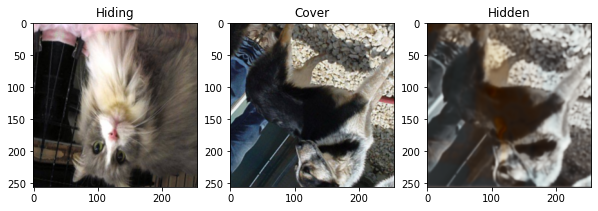

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


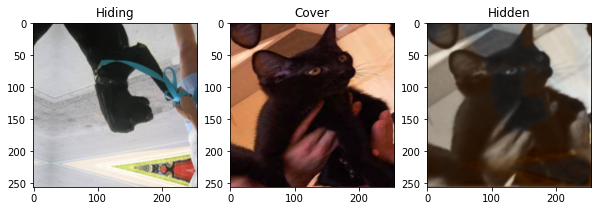

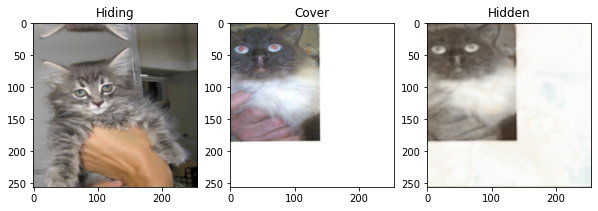

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


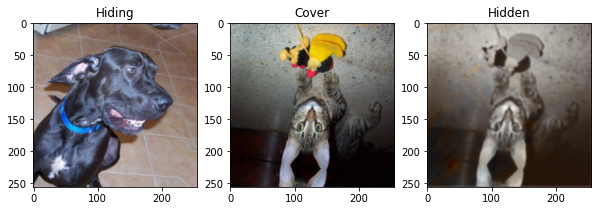

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


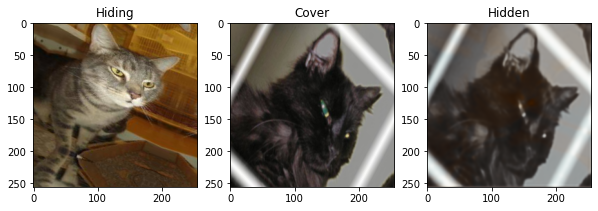

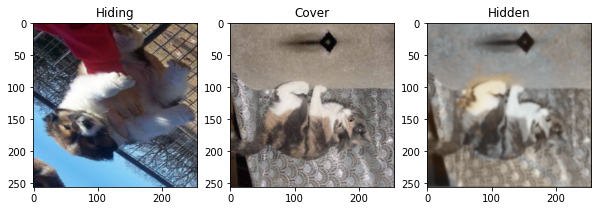

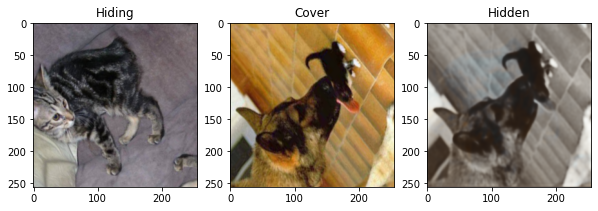

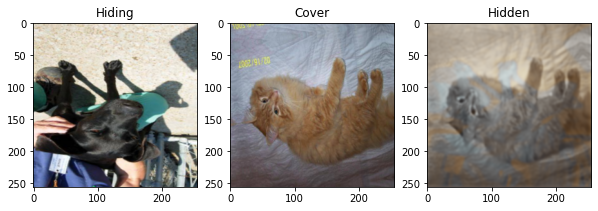

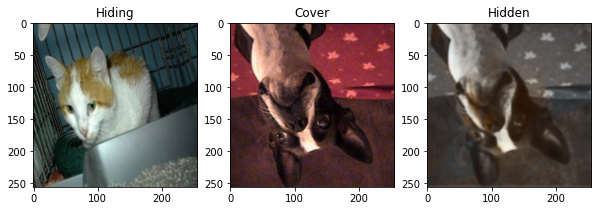

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


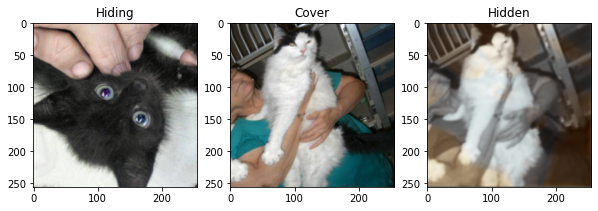

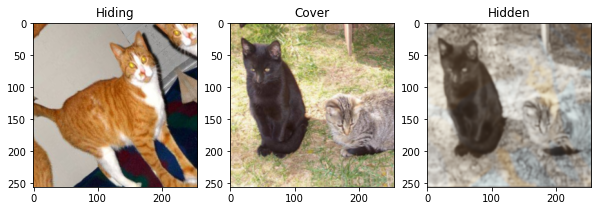

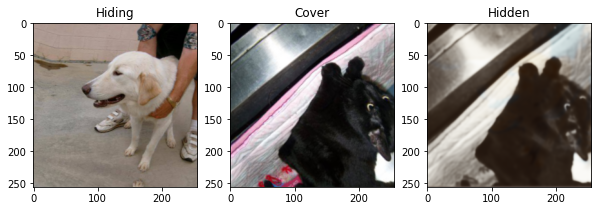

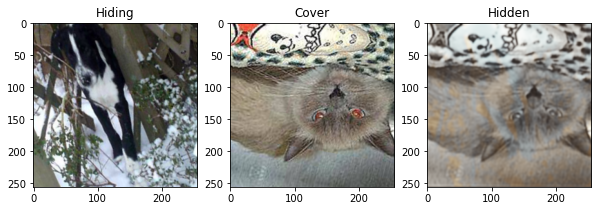

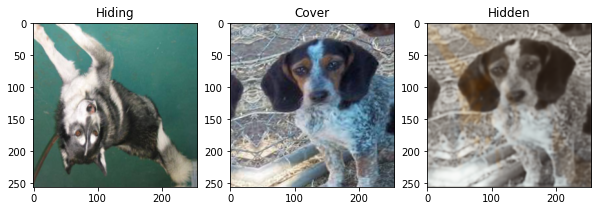

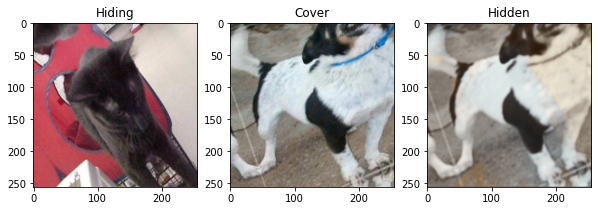

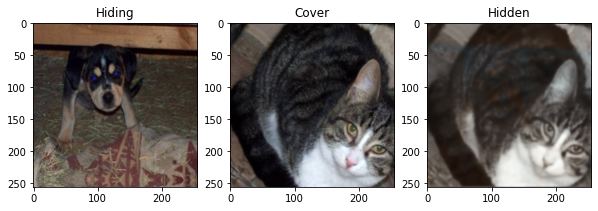

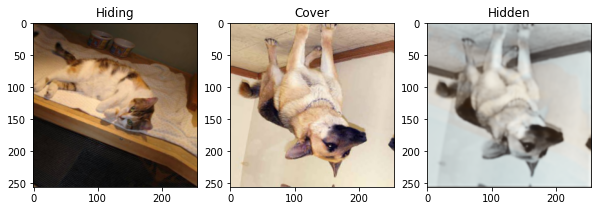

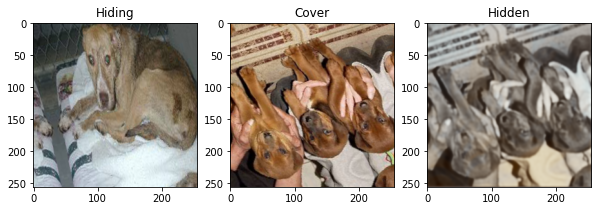

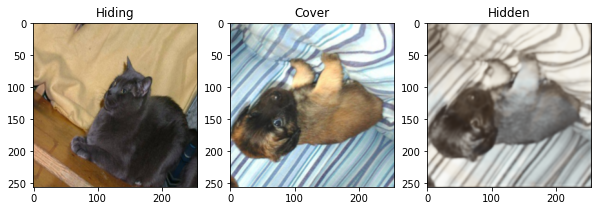

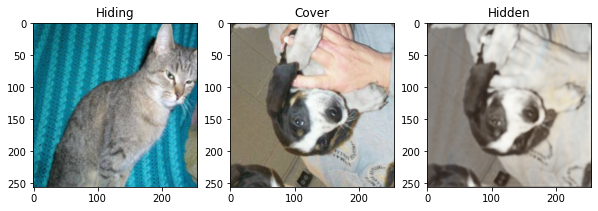

In [53]:
for i in range(batch_size):
    
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Hiding')
    ax1.imshow(batch_S[i])
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Cover')
    ax2.imshow(batch_C[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Hidden')
    ax3.imshow(preds[i])
    
    plt.show()

In [56]:
dec_preds= decoder.predict(preds)
print(dec_preds.shape)

(20, 256, 256, 3)


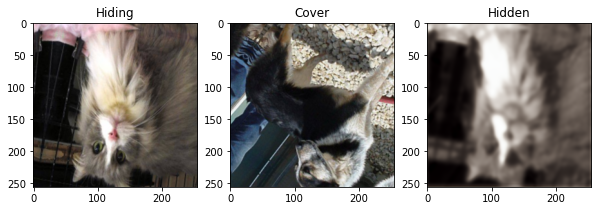

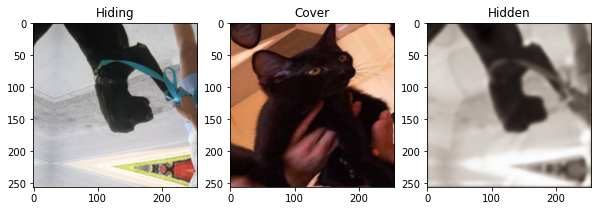

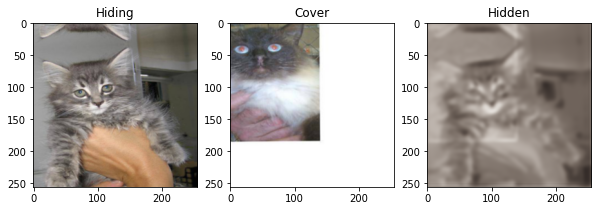

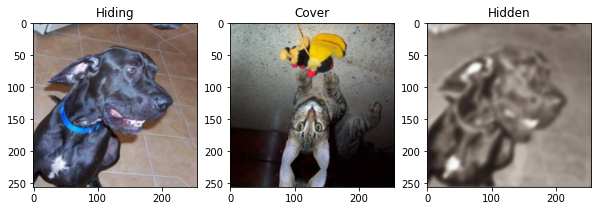

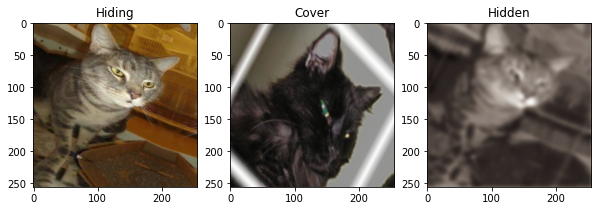

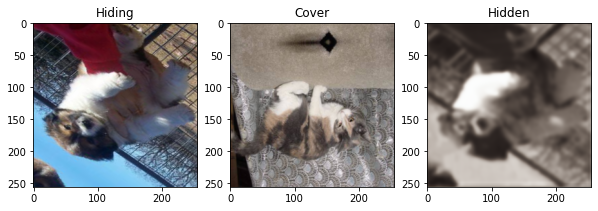

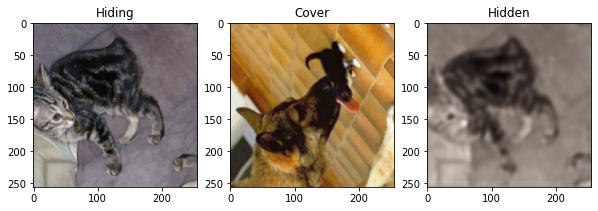

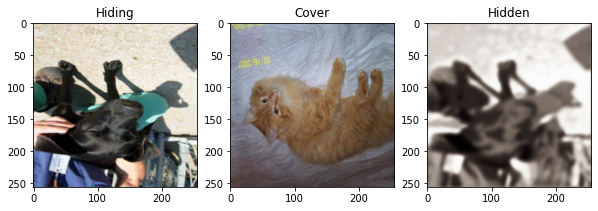

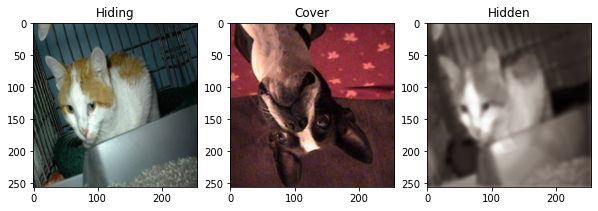

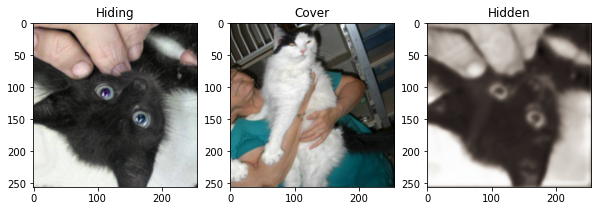

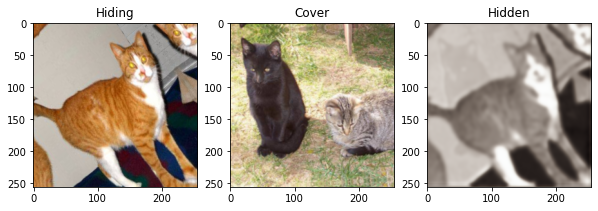

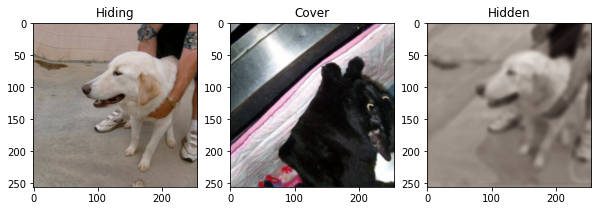

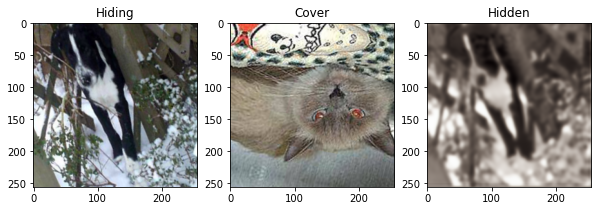

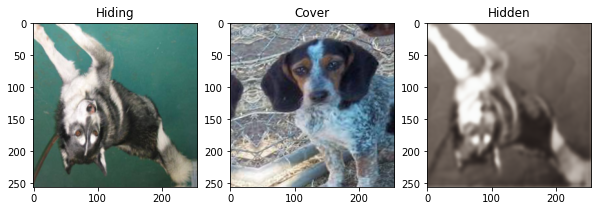

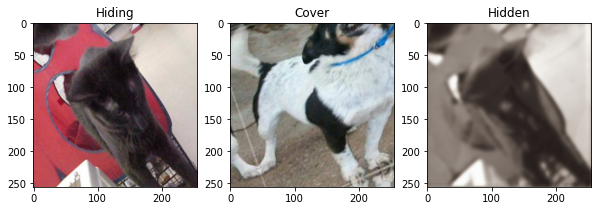

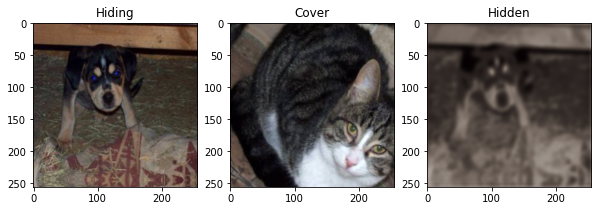

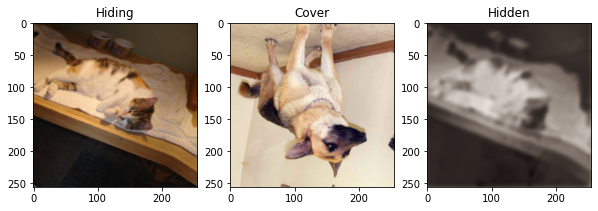

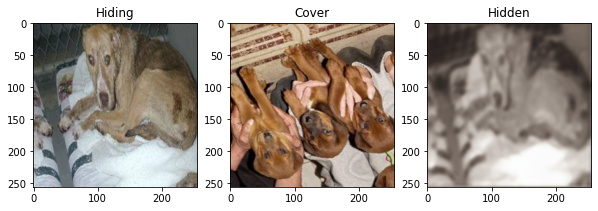

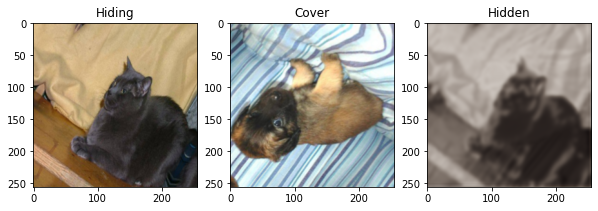

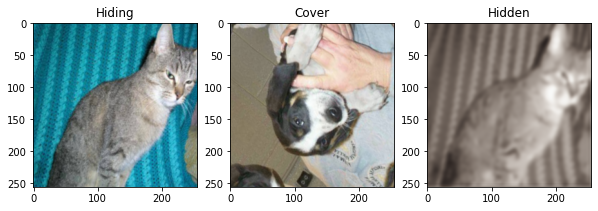

In [57]:
for i in range(batch_size):
    
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Hiding')
    ax1.imshow(batch_S[i])
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Cover')
    ax2.imshow(batch_C[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Hidden')
    ax3.imshow(dec_preds[i]/np.max(dec_preds))
    
    
    plt.show()